## Computer vision project. Определение пола по изображению знаменитостей в датасете celeba.

In [1]:
import tensorflow as tf
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import os
import pandas as pd

Загрузка данного датасета через tensorflow_datasets не увенчалась успехом по неизвестной причине, поэтому датасет был загружен на ПК и далее загружен в Jupyter

Загрузим список всех признаков для каждого изображения. Нас интересует пол человека на изображении.

In [2]:
attr_df = pd.read_csv('C:/dataset/celeb_a/list_attr_celeba.csv',index_col=0)

In [64]:
attr_df.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [66]:
print(attr_df.columns)

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')


In [70]:
labels = attr_df['Male'].replace(-1,0).values

Займемся самими изображениями людей. Разметим данные в один датасет

In [3]:
dataset_dir = 'C:/dataset/celeb_a/img_align_celeba/'

In [4]:
image_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    image_size=(218, 178),  
    batch_size=None,
    shuffle=False,
    labels=None
)

Found 202599 files.


In [5]:
def add_labels(images, labels):
    return tf.data.Dataset.zip((images, tf.data.Dataset.from_tensor_slices(labels)))

full_ds = add_labels(image_ds, labels)

Цветные изображения (3) 218x178 пикселей

In [56]:
for images, labels in full_ds.take(1):
    print(images.shape, labels.shape)

(218, 178, 3) ()


Разделим на тренировочный, проверочный и тестовый набор данных

In [7]:
train_ds = full_ds.take(10000)
valid_ds = full_ds.skip(10000).take(2000)
test_ds = full_ds.skip(12000).take(2000)

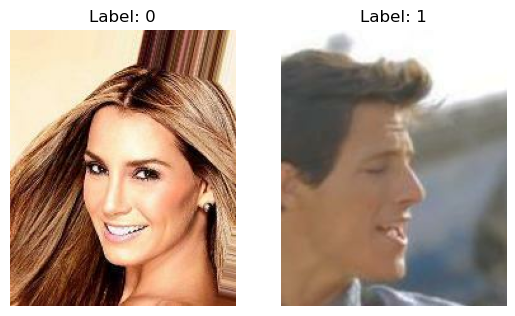

In [10]:
from tensorflow.keras.preprocessing import image
example_woman = train_ds.take(1)
example_man = train_ds.skip(2).take(1)
images, labels = next(iter(example_woman))

fig, ax = plt.subplots(1,2)
ax[0].imshow(images.numpy().astype('uint8'))
ax[0].set_title(f'Label: {labels}')
ax[0].axis('off') 
images, labels = next(iter(example_man))
ax[1].imshow(images.numpy().astype('uint8')) 
ax[1].set_title(f'Label: {labels}')
ax[1].axis('off')  

plt.show()  

Создадим функцию для подготовки данных. В ней мы нормализуем изображения, а также применим к ним небольшие случайные изменения, которые будут продемонстрированы ниже

In [11]:
def preprocess(image,label, size=(64, 64), mode='train'):

    if mode == 'train':
        image_cropped = tf.image.random_crop(
            image, size=(178, 178, 3))
        image_resized = tf.image.resize(
            image_cropped, size=size)
        image_flip = tf.image.random_flip_left_right(
            image_resized)
        return (image_flip/255.0, tf.cast(label, tf.int32))
    
    else:
        image_cropped = tf.image.crop_to_bounding_box(
            image, offset_height=20, offset_width=0,
            target_height=178, target_width=178)
        image_resized = tf.image.resize(
            image_cropped, size=size)
        return (image_resized/255.0, tf.cast(label, tf.int32))

Ниже пример случайных трансформаций. Они будут применяться только к обучающему набору данных. Случайные изменения сделаны для демонстрации ситуации, когда набор данных ограничен и требуется создать больше образцов во избежание переобучения. В нашем случае данных достаточно.

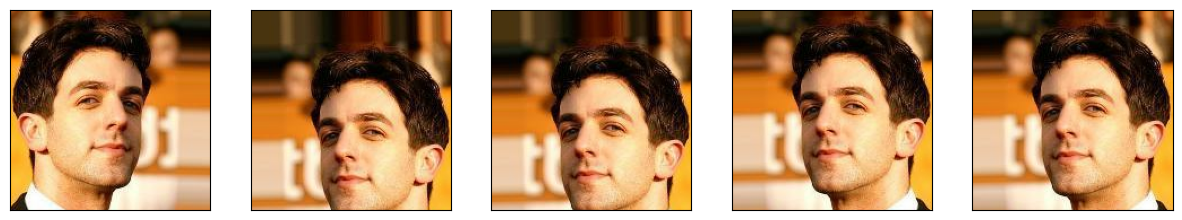

In [88]:
tf.random.set_seed(1)

ds = train_ds.shuffle(1000, reshuffle_each_iteration=False)
ds = ds.take(1).repeat(5)
ds = ds.map(lambda x, lbl: preprocess(x, lbl, size=(178, 178), mode='train'))

fig = plt.figure(figsize=(15, 6))
num=1
for j,example in enumerate(ds):
    ax = fig.add_subplot(1, 5, num)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(example[0])
    num+=1
    
plt.show()

Подготовим данные

In [94]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
IMAGE_SIZE = (64, 64)
steps_per_epoch = int(np.ceil(10000/BATCH_SIZE))

train_ds_transform = train_ds.map(
    lambda x, lbl: preprocess(x, lbl, size=IMAGE_SIZE, mode='train'))
train_ds_transform = train_ds_transform.shuffle(buffer_size=BUFFER_SIZE).repeat()
train_ds_transform = train_ds_transform.batch(BATCH_SIZE)

valid_ds_transform = valid_ds.map(
    lambda x, lbl: preprocess(x, lbl, size=IMAGE_SIZE, mode='eval'))
valid_ds_transform = valid_ds_transform.batch(BATCH_SIZE)


Создадим нейронную сеть на основе сверточных слоев, объединений по максимуму и слоями отключения для уменьшения переобучения.

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Conv2D(
        64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Conv2D(
        128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(
        256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation=None)
])

In [16]:
tf.random.set_seed(1)
model.build(input_shape=(None, 64, 64, 3))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,673 (1.48 MB)

 Trainable params: 388,673 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_ds_transform, validation_data=valid_ds_transform, 
                    epochs=35, steps_per_epoch=steps_per_epoch)


Epoch 1/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 94s 293ms/step - accuracy: 0.5822 - loss: 0.6783 - val_accuracy: 0.5855 - val_loss: 0.6367
Epoch 2/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 290ms/step - accuracy: 0.6546 - loss: 0.5929 - val_accuracy: 0.7410 - val_loss: 0.5689
Epoch 3/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 292ms/step - accuracy: 0.7110 - loss: 0.5391 - val_accuracy: 0.7360 - val_loss: 0.4962
Epoch 4/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 293ms/step - accuracy: 0.7336 - loss: 0.5095 - val_accuracy: 0.7945 - val_loss: 0.4609
Epoch 5/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 291ms/step - accuracy: 0.7821 - loss: 0.4540 - val_accuracy: 0.8045 - val_loss: 0.4144
Epoch 6/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 292ms/step - accuracy: 0.7814 - loss: 0.4356 - val_accuracy: 0.8170 - val_loss: 0.4051
Epoch 7/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 92s 292ms/step - accuracy: 0.7977 - loss: 0.4158 - val_accuracy: 0.8280 - val_loss: 0.3647
Epoch 8/35
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 288ms/step - accuracy: 0.8085 - loss: 0

In [50]:
test_ds_transform = test_ds.map(lambda x, lbl:preprocess(x, lbl, size=IMAGE_SIZE, mode='eval')).batch(32)
results = model.evaluate(test_ds_transform, verbose=0)
print('Test Acc: {:.2f}%'.format(results[1]*100))

Test Acc: 91.50%


Text(0, 0.5, 'Accuracy')

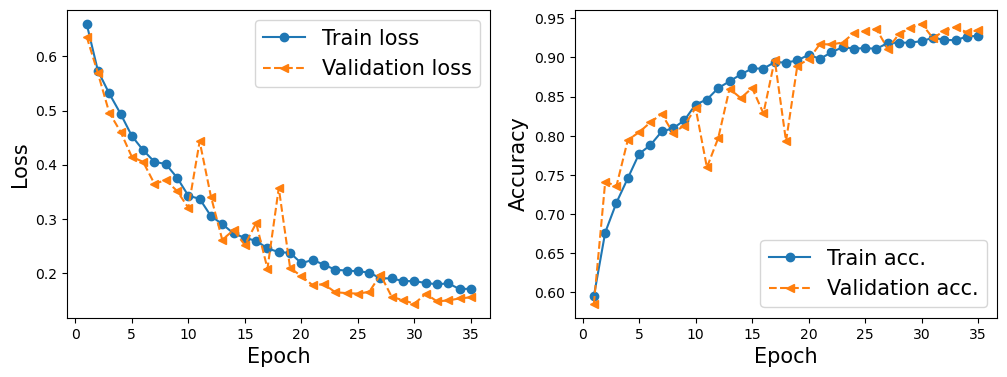

In [52]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

По оценке на тестовом наборе и по кривым обучения можно сделать вывод, что нейросеть более чем с 90% точностью справляется с классификацией пола человека на изображении. Кривая обучения и проверки на validate наборе почти сошлись. Можно было бы провести обучение до 40 эпох и посмотреть результат, но ресурсы и время ограничены в моем случае.

Ниже для большей демонстрации выведем 10 образцов из тестового набора и оценим вероятность принадлежности к классу 1 (мужской пол) и сравним результат с истиной

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


C:\ProgramData\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


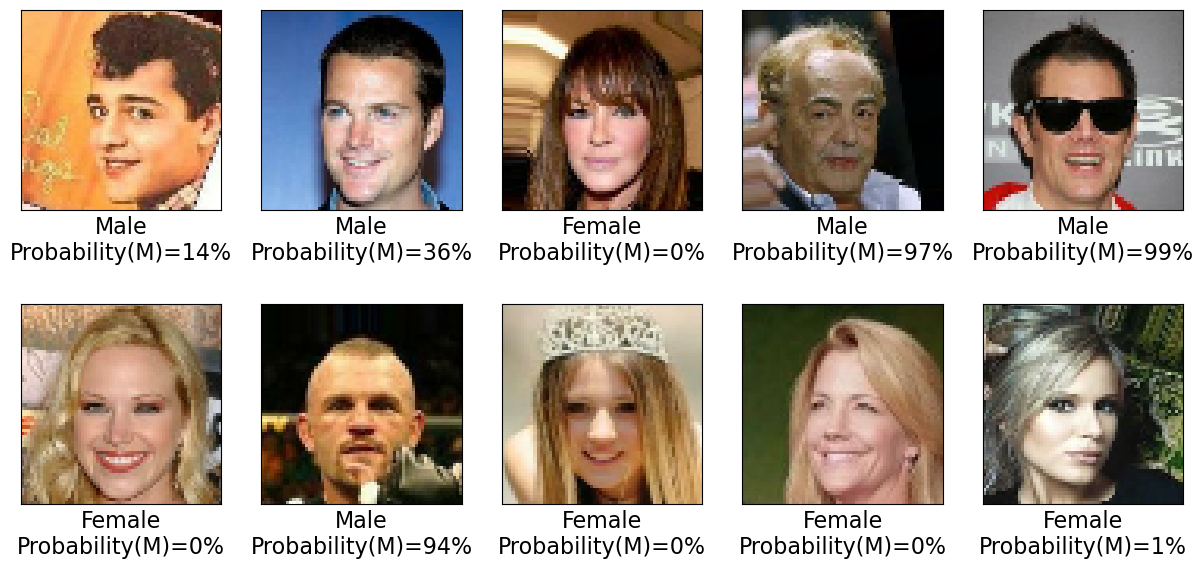

In [106]:
ds_ = test_ds_transform.unbatch().take(10)

pred_logits = model.predict(ds_.batch(10))
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

fig = plt.figure(figsize=(15, 7))
for j,example in enumerate(ds_):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    if example[1].numpy() == 1:
        label='Male'
    else:
        label = 'Female'
    ax.text(
        0.5, -0.15, 
        '{:s}\nProbability(M)={:.0f}%'.format(label, probas[j]), 
        size=16, 
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
plt.show()